<a href="https://colab.research.google.com/github/ipejun-ai/m5-accuracy/blob/master/m5_forecast_keras_with_categorical_embeddings_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M5 Forecast: Keras with Categorical Embeddings V2

This notebook tries to model expected sales of product groups. Since many of the features are categorical, we use this example to show how embedding layers make life easy when dealing with categoric inputs for neural nets by skipping the step of making dummy variables by hand.

Data preprocessing and feature engineering is very similar (but not identical) to this [R kernel](https://www.kaggle.com/mayer79/m5-forecast-keras-embeddings-with-r) and uses ideas from the two excellent kernels [Very fst Model](https://www.kaggle.com/ragnar123/very-fst-model) and [M5 ForecasteR](https://www.kaggle.com/kailex/m5-forecaster-0-57330).

To gain an extra 3 GB of RAM, we do not use GPU acceleration for the training.

In [0]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
from tqdm.notebook import tqdm

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Load data

In [63]:
#Load google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
DIRPATH="/content/gdrive/My Drive/kaggle/m5-forecasting-accuracy/"
#DIRPATH="C:/Users/peiju/Documents/Study/kaggle/m5-forecasting-accuracy/"

In [0]:
path = DIRPATH
output=DIRPATH+"output/m5-forecast-keras-with-categorical-embeddings-v2/"
VER=1

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [0]:
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

## Describe and prepare data

We will now go through all data sets and prepare them for modelling.

### Calendar data

For each date (covering both training and test data), we have access to useful calendar information.

In [67]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


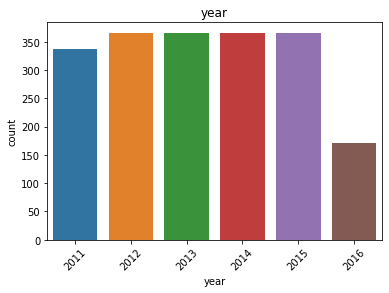

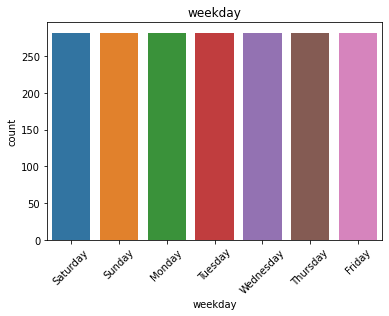

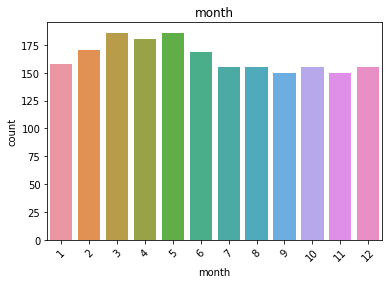

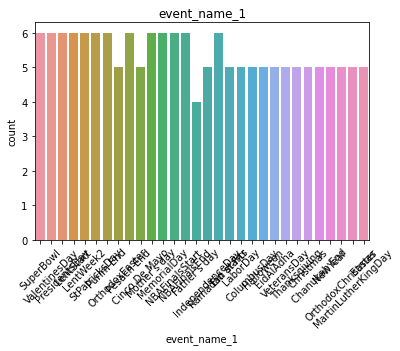

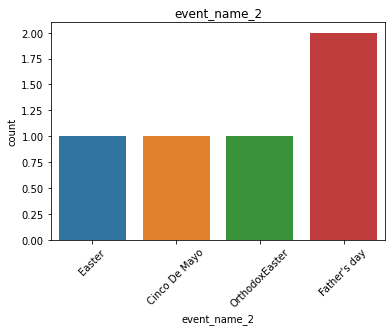

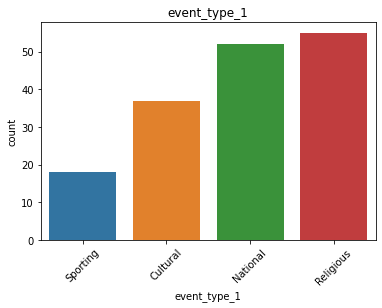

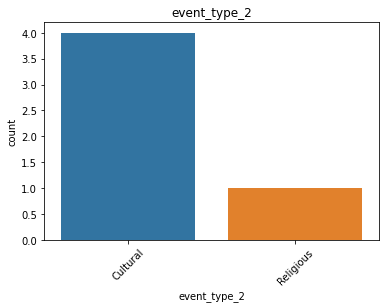

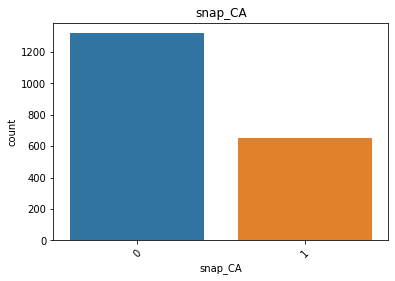

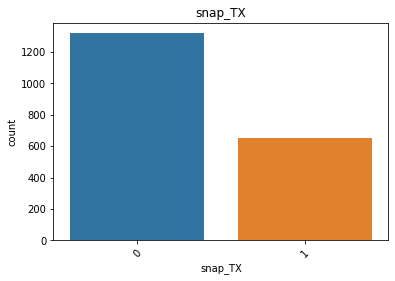

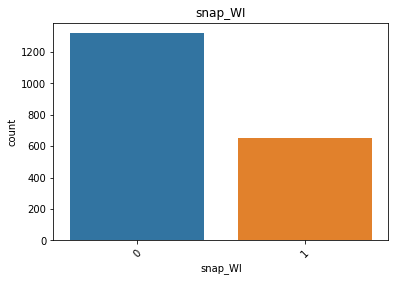

In [68]:
for i, var in enumerate(["year", "weekday", "month", "event_name_1", "event_name_2", 
                         "event_type_1", "event_type_2", "snap_CA", "snap_TX", "snap_WI"]):
    plt.figure()
    g = sns.countplot(calendar[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

In [69]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("missing")
    cols = list(set(df.columns) - {"wm_yr_wk", "d"})
    df[cols] = OrdinalEncoder(dtype="int").fit_transform(df[cols])
    df = reduce_mem_usage(df)
    return df

calendar = prep_calendar(calendar)

Mem. usage decreased to  0.03 Mb (85.4% reduction)


In [70]:
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,11101,0,0,0,1,30,4,4,2,0,0,0
1,11101,1,0,0,2,30,4,4,2,0,0,0
2,11101,2,0,0,3,30,4,4,2,0,0,0
3,11101,3,1,0,4,30,4,4,2,1,1,0
4,11101,4,1,0,5,30,4,4,2,1,0,1


#### Notes for modeling

**Features** deemed to be useful:

- "wday", "year", "month" -> integer coding & embedding
- "event_name_1", "event_type_1" -> integer coding & embedding
- "snap_XX" -> numeric (they are dummies)

**Reshape required**: No

**Merge key(s)**: "d", "wm_yr_wk"

### Selling prices

Contains selling prices for each store_id, item_id_wm_yr_wk combination.

In [71]:
selling_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


Derive some time related features:

In [72]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df = reduce_mem_usage(df)
    return df

selling_prices = prep_selling_prices(selling_prices)

Mem. usage decreased to 169.63 Mb (53.6% reduction)


In [73]:
selling_prices.tail()

,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
6841116,WI_3,FOODS_3_827,11617,1.0,0.0,0.0,0.0
6841117,WI_3,FOODS_3_827,11618,1.0,0.0,0.0,0.0
6841118,WI_3,FOODS_3_827,11619,1.0,0.0,0.0,0.0
6841119,WI_3,FOODS_3_827,11620,1.0,0.0,0.0,0.0
6841120,WI_3,FOODS_3_827,11621,1.0,0.0,0.0,0.0


#### Notes for modeling

**Features**:

- sell_price and derived features -> numeric

**Reshape**: No

**Merge key(s)**: to sales data by store_id, item_id, wm_yr_wk (through calendar data)

### Sales data

Contains the number of sold items (= our response) as well as some categorical features.

In [74]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


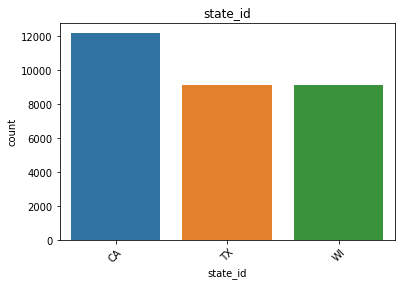

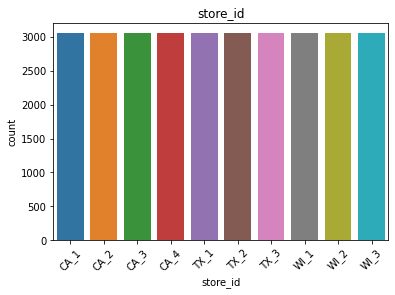

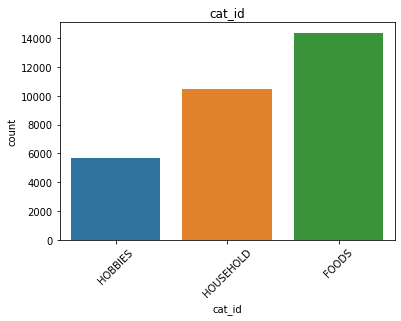

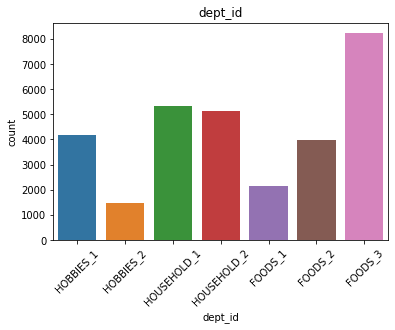

In [75]:
for i, var in enumerate(["state_id", "store_id", "cat_id", "dept_id"]):
    plt.figure()
    g = sns.countplot(sales[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

In [76]:
sales.item_id.value_counts()

FOODS_1_032        10
FOODS_3_769        10
HOUSEHOLD_1_226    10
HOBBIES_1_375      10
FOODS_3_368        10
                   ..
FOODS_3_817        10
HOUSEHOLD_2_351    10
HOBBIES_1_102      10
HOBBIES_2_130      10
FOODS_2_089        10
Name: item_id, Length: 3049, dtype: int64

#### Reshaping

We now reshape the data from wide to long, using "id" as fixed and swapping "d_x" columns. Along this process, we also add structure for submission data and reduce data size.

In [0]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"))
    return df

sales = reshape_sales(sales, 1000)

In [78]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1001,2.0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1001,1.0


#### Distribution of the response

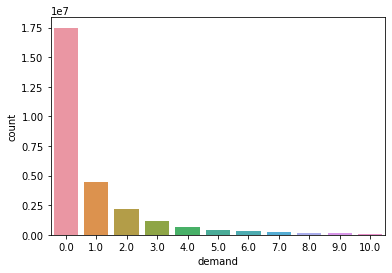

In [79]:
sns.countplot(sales["demand"][sales["demand"] <= 10]);

#### Add time-lagged features

Add some of the derived features from kernel https://www.kaggle.com/ragnar123/very-fst-model.

In [80]:
def prep_sales(df):
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    df['rolling_mean_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t60'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df['rolling_mean_t90'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['rolling_mean_t180'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['rolling_std_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())

    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_t180))]
    df = reduce_mem_usage(df)

    return df

sales = prep_sales(sales)

Mem. usage decreased to 1683.94 Mb (41.5% reduction)


In [81]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30
6311430,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,0.399902,0.383301,0.399902,0.511230,0.755859,0.621582
6311431,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,0.166626,0.133301,0.122192,0.144409,0.488037,0.379150
6311432,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,0.433350,0.316650,0.333252,0.166626,0.488037,0.728027
6311433,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,2.433594,2.533203,2.445312,2.339844,1.272461,2.298828
6311434,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,0.700195,0.750000,0.855469,0.816895,1.154297,0.915527


#### Notes for modeling

**Features**
- "dept_id", "item_id", "store_id": Integer coding & embedding
- lagged features derived from response: Numeric

**Reshape**:
- Reshape days as "d" from wide to long -> "demand" will be response variable

**Merges**:
1. Join calendar features by "d"
2. Join selling prices by "store_id", "item_id" and ("wm_yr_wk" from calendar)

Comment: Submission dates: "d_1914" - "d_1969"

### Combine data sources

In [82]:
sales = sales.merge(calendar, how="left", on="d")
gc.collect()
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,0.399902,0.383301,0.399902,0.511230,0.755859,0.621582,11416,3,4,3,30,4,4,2,0,0,0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,0.166626,0.133301,0.122192,0.144409,0.488037,0.379150,11416,3,4,3,30,4,4,2,0,0,0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,0.433350,0.316650,0.333252,0.166626,0.488037,0.728027,11416,3,4,3,30,4,4,2,0,0,0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,2.433594,2.533203,2.445312,2.339844,1.272461,2.298828,11416,3,4,3,30,4,4,2,0,0,0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,0.700195,0.750000,0.855469,0.816895,1.154297,0.915527,11416,3,4,3,30,4,4,2,0,0,0


In [83]:
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,0.399902,0.383301,0.399902,0.511230,0.755859,0.621582,3,4,3,30,4,4,2,0,0,0,8.257812,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,0.166626,0.133301,0.122192,0.144409,0.488037,0.379150,3,4,3,30,4,4,2,0,0,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,0.433350,0.316650,0.333252,0.166626,0.488037,0.728027,3,4,3,30,4,4,2,0,0,0,2.970703,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,2.433594,2.533203,2.445312,2.339844,1.272461,2.298828,3,4,3,30,4,4,2,0,0,0,4.640625,0.0,0.0,0.230713
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,0.700195,0.750000,0.855469,0.816895,1.154297,0.915527,3,4,3,30,4,4,2,0,0,0,3.080078,0.0,0.0,0.375000


In [0]:
del selling_prices

In [85]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23233380 entries, 0 to 23233379
Data columns (total 30 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   object 
 1   item_id              object 
 2   dept_id              object 
 3   cat_id               object 
 4   store_id             object 
 5   state_id             object 
 6   d                    int16  
 7   demand               float16
 8   lag_t28              float16
 9   rolling_mean_t7      float16
 10  rolling_mean_t30     float16
 11  rolling_mean_t60     float16
 12  rolling_mean_t90     float16
 13  rolling_mean_t180    float16
 14  rolling_std_t7       float16
 15  rolling_std_t30      float16
 16  wday                 int8   
 17  month                int8   
 18  year                 int8   
 19  event_name_1         int8   
 20  event_type_1         int8   
 21  event_name_2         int8   
 22  event_type_2         int8   
 23  snap_CA              int8   
 

## Prepare data for Keras interface

### Ordinal encoding of remaining categoricals

In [86]:
cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]
cat_cols = cat_id_cols + ["wday", "month", "year", "event_name_1", 
                          "event_type_1", "event_name_2", "event_type_2"]

# In loop to minimize memory use
for i, v in tqdm(enumerate(cat_id_cols)):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]])

sales = reduce_mem_usage(sales)
sales.head()
gc.collect()


Mem. usage decreased to 1329.42 Mb (36.2% reduction)


6

#### Impute numeric columns

In [87]:
num_cols = ["sell_price", "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_cumrel",
            "lag_t28", "rolling_mean_t7", "rolling_mean_t30", "rolling_mean_t60", 
            "rolling_mean_t90", "rolling_mean_t180", "rolling_std_t7", "rolling_std_t30"]
bool_cols = ["snap_CA", "snap_TX", "snap_WI"]
dense_cols = num_cols + bool_cols

# Need to do column by column due to memory constraints
for i, v in tqdm(enumerate(num_cols)):
    sales[v] = sales[v].fillna(sales[v].median())
    
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,1208,2.0,0.0,0.714355,0.399902,0.383301,0.399902,0.511230,0.755859,0.621582,3,4,3,30,4,4,2,0,0,0,8.257812,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,1208,1.0,1.0,0.285645,0.166626,0.133301,0.122192,0.144409,0.488037,0.379150,3,4,3,30,4,4,2,0,0,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,1208,1.0,0.0,0.285645,0.433350,0.316650,0.333252,0.166626,0.488037,0.728027,3,4,3,30,4,4,2,0,0,0,2.970703,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,1208,1.0,4.0,2.572266,2.433594,2.533203,2.445312,2.339844,1.272461,2.298828,3,4,3,30,4,4,2,0,0,0,4.640625,0.0,0.0,0.230713
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,1208,0.0,0.0,1.000000,0.700195,0.750000,0.855469,0.816895,1.154297,0.915527,3,4,3,30,4,4,2,0,0,0,3.080078,0.0,0.0,0.375000


#### Separate submission data and reconstruct id columns

In [88]:
test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
test.head()
gc.collect()

0

#### Make training data

In [89]:
# Input dict for training with a dense array and separate inputs for each embedding input
def make_X(df):
    X = {"dense1": df[dense_cols].to_numpy()}
    for i, v in enumerate(cat_cols):
        X[v] = df[[v]].to_numpy()
    return X

# Submission data
X_test = make_X(test)

# One month of validation data
flag = (sales.d < 1914) & (sales.d >= 1914 - 28)
valid = (make_X(sales[flag]),
         sales["demand"][flag])
valid_sales=sales[flag]
# Rest is used for training
flag = sales.d < 1914 - 28
X_train = make_X(sales[flag])
y_train = sales["demand"][flag]
                             
del sales, flag
gc.collect()

69

In [31]:
np.unique(X_train["state_id"])

array([0, 1, 2], dtype=int8)

In [35]:
X_train

{'cat_id': array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]], dtype=int8),
 'dense1': array([[8.26, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [3.97, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [2.97, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [3.98, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [1.28, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float16),
 'dept_id': array([[3],
        [3],
        [3],
        ...,
        [2],
        [2],
        [2]], dtype=int8),
 'event_name_1': array([[30],
        [30],
        [30],
        ...,
        [ 4],
        [ 4],
        [ 4]], dtype=int8),
 'event_name_2': array([[4],
        [4],
        [4],
        ...,
        [4],
        [4],
        [4]], dtype=int8),
 'event_type_1': array([[4],
        [4],
        [4],
        ...,
        [0],
        [0],
        [0]], dtype=int8),
 'event_type_2': array([[2],
        [2],
        [2],

## The model

### Imports

In [0]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten
from tensorflow.keras.models import Model

### Architecture with embeddings

In [0]:
def create_model(lr=0.002):
    tf.random.set_seed(173)

    tf.keras.backend.clear_session()
    gc.collect()

    # Dense input
    dense_input = Input(shape=(len(dense_cols), ), name='dense1')

    # Embedding input
    wday_input = Input(shape=(1,), name='wday')
    month_input = Input(shape=(1,), name='month')
    year_input = Input(shape=(1,), name='year')
    event_name_1_input = Input(shape=(1,), name='event_name_1')
    event_type_1_input = Input(shape=(1,), name='event_type_1')
    event_name_2_input = Input(shape=(1,), name='event_name_2')
    event_type_2_input = Input(shape=(1,), name='event_type_2')
    item_id_input = Input(shape=(1,), name='item_id')
    dept_id_input = Input(shape=(1,), name='dept_id')
    store_id_input = Input(shape=(1,), name='store_id')
    cat_id_input = Input(shape=(1,), name='cat_id')
    state_id_input = Input(shape=(1,), name='state_id')

    wday_emb = Flatten()(Embedding(7, 1)(wday_input))
    month_emb = Flatten()(Embedding(12, 1)(month_input))
    year_emb = Flatten()(Embedding(6, 1)(year_input))
    event_name_1_emb = Flatten()(Embedding(31, 1)(event_name_1_input))
    event_type_1_emb = Flatten()(Embedding(5, 1)(event_type_1_input))
    event_name_2_emb = Flatten()(Embedding(5, 1)(event_name_2_input))
    event_type_2_emb = Flatten()(Embedding(5, 1)(event_type_2_input))

    item_id_emb = Flatten()(Embedding(3049, 3)(item_id_input))
    dept_id_emb = Flatten()(Embedding(7, 1)(dept_id_input))
    store_id_emb = Flatten()(Embedding(10, 1)(store_id_input))
    cat_id_emb = Flatten()(Embedding(3, 1)(cat_id_input))
    state_id_emb = Flatten()(Embedding(3, 1)(state_id_input))

    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, wday_emb, month_emb, year_emb, 
                     event_name_1_emb, event_type_1_emb, 
                     event_name_2_emb, event_type_2_emb, 
                     item_id_emb, dept_id_emb, store_id_emb,
                     cat_id_emb, state_id_emb])
    x = Dense(150, activation="tanh")(x)
    x = Dense(75, activation="tanh")(x)
    x = Dense(10, activation="tanh")(x)
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = {"dense1": dense_input, "wday": wday_input, "month": month_input, "year": year_input, 
              "event_name_1": event_name_1_input, "event_type_1": event_type_1_input,
              "event_name_2": event_name_2_input, "event_type_2": event_type_2_input,
              "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input, 
              "cat_id": cat_id_input, "state_id": state_id_input}

    # Connect input and output
    model = Model(inputs, outputs)

    model.compile(loss=keras.losses.mean_squared_error,
                  metrics=["mse"],
                  optimizer=keras.optimizers.RMSprop(learning_rate=lr))
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wday (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
year (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
event_name_1 (InputLayer)       [(None, 1)]          0                                            
______________________________________________________________________________________________

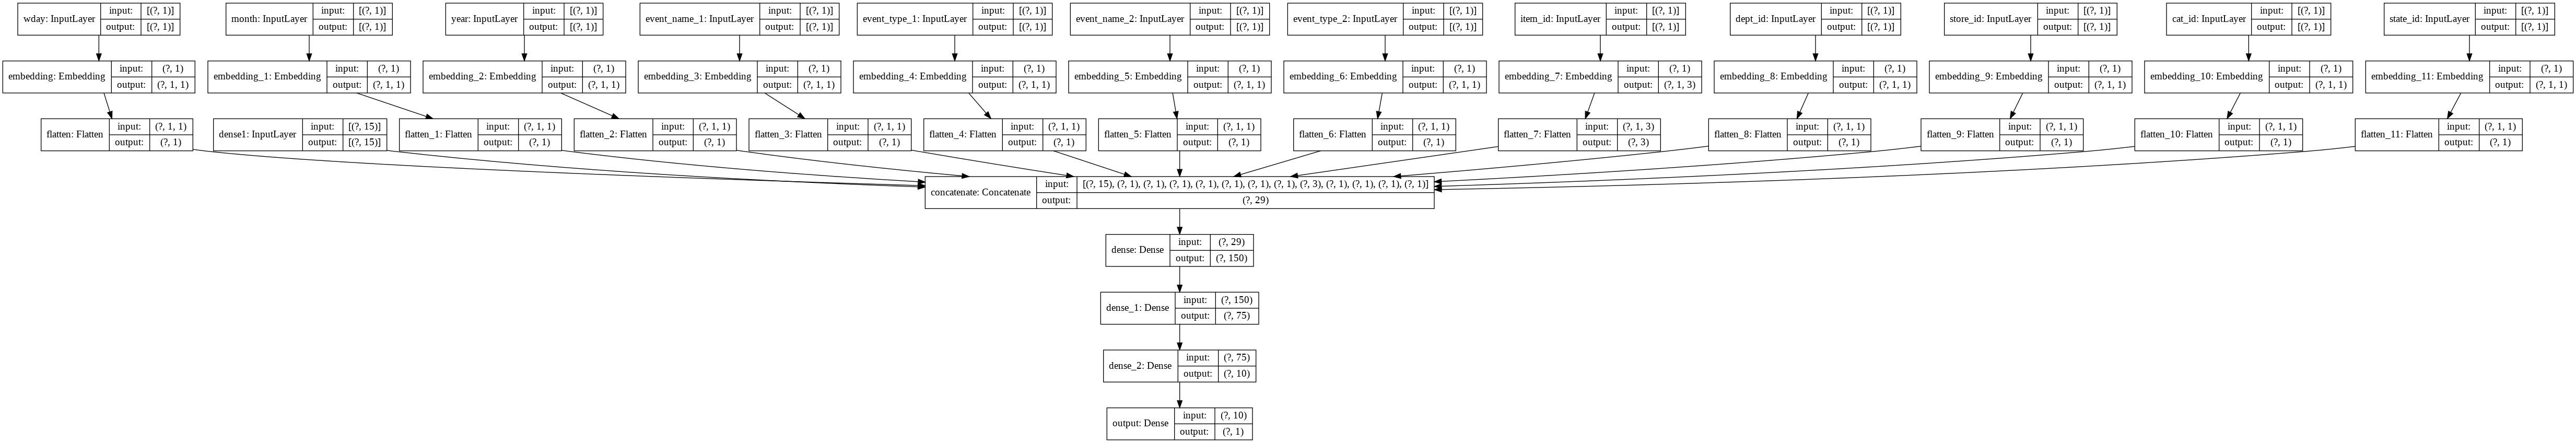

In [38]:
model = create_model(0.0002)
model.summary()
keras.utils.plot_model(model, 'model.png', show_shapes=True)

### Calculate derivatives and fit model

In [39]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=10000,
                    epochs=30,
                    shuffle=True,
                    validation_data=valid)

Epoch 1/30
2068/2068 [==============================] - 19s 9ms/step - loss: 9.5809 - mse: 9.5809 - val_loss: 8.3482 - val_mse: 8.3482
Epoch 2/30
2068/2068 [==============================] - 18s 9ms/step - loss: 8.1711 - mse: 8.1711 - val_loss: 7.2305 - val_mse: 7.2305
Epoch 3/30
2068/2068 [==============================] - 18s 9ms/step - loss: 7.4166 - mse: 7.4166 - val_loss: 6.5775 - val_mse: 6.5775
Epoch 4/30
2068/2068 [==============================] - 19s 9ms/step - loss: 6.9456 - mse: 6.9456 - val_loss: 6.2320 - val_mse: 6.2320
Epoch 5/30
2068/2068 [==============================] - 18s 9ms/step - loss: 6.6343 - mse: 6.6343 - val_loss: 5.9005 - val_mse: 5.9005
Epoch 6/30
2068/2068 [==============================] - 18s 9ms/step - loss: 6.4098 - mse: 6.4098 - val_loss: 5.6896 - val_mse: 5.6896
Epoch 7/30
2068/2068 [==============================] - 19s 9ms/step - loss: 6.2435 - mse: 6.2435 - val_loss: 5.5625 - val_mse: 5.5625
Epoch 8/30
2068/2068 [==============================] -

#### Plot the evaluation metrics over epochs

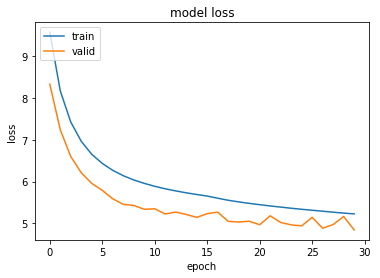

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [41]:
history.history["val_loss"]

[8.348153114318848,
 7.2305216789245605,
 6.577475547790527,
 6.2320356369018555,
 5.900484561920166,
 5.689581394195557,
 5.562527656555176,
 5.481047630310059,
 5.47871732711792,
 5.371032238006592,
 5.287023067474365,
 5.245237827301025,
 5.185178756713867,
 5.166994094848633,
 5.20501708984375,
 5.1161394119262695,
 5.086450576782227,
 5.039863109588623,
 5.361051082611084,
 4.969526290893555,
 4.996999740600586,
 5.0168914794921875,
 4.932548522949219,
 4.9176459312438965,
 4.935189723968506,
 4.966318130493164,
 4.906402111053467,
 4.9678215980529785,
 4.899567604064941,
 4.810749053955078]

In [0]:
model.save('model.h5')
model.save(output+"model"+str(VER)+".h5")

# Validation

In [0]:
pred = model.predict(valid, batch_size=10000)

In [58]:
valid

({'cat_id': array([[1],
         [1],
         [1],
         ...,
         [0],
         [0],
         [0]], dtype=int8),
  'dense1': array([[8.26, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [3.97, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [2.97, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         ...,
         [3.98, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [1.28, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float16),
  'dept_id': array([[3],
         [3],
         [3],
         ...,
         [2],
         [2],
         [2]], dtype=int8),
  'event_name_1': array([[30],
         [30],
         [30],
         ...,
         [30],
         [30],
         [30]], dtype=int8),
  'event_name_2': array([[4],
         [4],
         [4],
         ...,
         [4],
         [4],
         [4]], dtype=int8),
  'event_type_1': array([[4],
         [4],
         [4],
         ...,
         [4],
         [4],
         [4]], dtype=int8),
  'event_typ

In [0]:
valid_sales["id"]=valid_sales["id"]+"_validation"

In [0]:
valid_sales["demand"] = pred.clip(0)
submission = valid_sales.pivot(index="id", columns="d", values="demand")
submission = sample_submission[["id"]].merge(submission, how="left", on="id")
submission=submission.dropna(axis=0)
submission.head()
submission.to_csv(output+"validation_"+str(VER)+".csv", index=False)
all_preds=submission.drop("id",axis=1)

In [139]:
submission

,id,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913
0,HOBBIES_1_001_CA_1_validation,0.742573,0.769643,0.711016,0.765854,0.848109,0.868906,0.941051,0.686472,0.613144,0.641365,0.651029,0.798978,0.902507,0.906660,0.615781,0.627403,0.629188,0.647018,0.826360,0.952429,1.088827,0.790639,0.780992,0.771578,0.757780,0.842614,1.046530,1.047493
1,HOBBIES_1_002_CA_1_validation,0.237350,0.232902,0.225696,0.244798,0.276709,0.262997,0.342411,0.301562,0.311501,0.300871,0.324239,0.285140,0.392143,0.347358,0.304442,0.295153,0.297113,0.253520,0.286372,0.280811,0.284486,0.237215,0.229063,0.225129,0.265951,0.300622,0.355441,0.391335
2,HOBBIES_1_003_CA_1_validation,0.273547,0.266747,0.264614,0.264616,0.287162,0.683667,0.539282,0.471804,0.523881,0.485912,0.494183,0.488197,0.540950,0.553960,0.388616,0.357488,0.356129,0.352841,0.411586,0.430223,0.411444,0.350104,0.335697,0.334105,0.337257,0.379960,0.462538,0.440668
3,HOBBIES_1_004_CA_1_validation,1.885543,1.667310,1.626403,1.651164,1.859949,2.074434,2.369769,1.764710,1.590755,1.532556,1.598438,1.663245,2.031100,2.070692,1.524451,1.337852,1.412174,1.430279,1.786990,2.142722,2.198139,1.703038,1.502866,1.566910,1.709073,1.761736,2.452698,2.682490
4,HOBBIES_1_005_CA_1_validation,1.062487,1.056933,1.065164,1.000521,1.154513,1.254460,1.290180,1.068707,0.971196,0.965435,1.033578,1.100082,1.393327,1.532451,1.000784,0.914410,0.969596,0.856859,1.075964,1.410473,1.502771,1.121445,1.092280,1.068742,1.093917,1.193218,1.426077,1.419834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0.652755,0.614797,0.801610,0.717788,0.851552,1.329810,1.326509,0.908557,0.949047,0.935087,0.791788,0.949426,1.060524,0.765521,0.656152,0.610346,0.457088,0.508526,0.601275,0.437439,0.400896,0.303515,0.285295,0.282213,0.284320,0.308095,0.378371,0.367762
30486,FOODS_3_824_WI_3_validation,0.016949,0.020535,0.021630,0.018945,0.125130,1.150137,1.252233,0.896806,1.097011,1.095830,0.932153,1.038077,1.312452,1.060269,1.139602,1.117703,1.004294,1.023763,1.167767,1.127378,1.145064,0.998816,0.982450,0.980411,0.986474,1.019576,1.127378,1.145064
30487,FOODS_3_825_WI_3_validation,0.678953,0.703667,0.750246,0.824039,1.069446,1.424732,1.575939,1.055719,1.114380,1.122475,1.025850,1.336241,1.545133,1.304938,1.118423,1.176308,0.978929,1.074711,1.294650,1.198074,1.202384,1.021235,0.837576,0.802443,0.786875,0.966369,1.106915,1.217873
30488,FOODS_3_826_WI_3_validation,0.923530,0.896033,0.926421,0.985146,1.149308,1.505085,1.628669,1.027761,1.038072,0.982118,0.908402,0.992169,1.241114,1.225460,0.985087,1.066097,0.937716,0.974604,1.164868,1.202048,1.181953,0.924043,0.769516,0.854123,0.870641,0.973522,1.250088,1.493593


In [135]:
valid_sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
20672220,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1886,0.742573,0.0,1.142578,1.000000,0.883301,0.833496,0.710938,1.463867e+00,1.231445,2,2,5,30,4,4,2,0,0,0,8.257812,0.0,0.000000,0.000000
20672221,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1886,0.237350,0.0,0.142822,0.166626,0.150024,0.399902,0.366699,3.779297e-01,0.379150,2,2,5,30,4,4,2,0,0,0,3.970703,0.0,0.000000,0.000000
20672222,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1886,0.273547,0.0,0.000000,0.300049,0.250000,0.655762,0.661133,5.960464e-08,0.466064,2,2,5,30,4,4,2,0,0,0,2.970703,0.0,0.000000,0.000000
20672223,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1886,1.885543,0.0,1.857422,2.199219,2.066406,1.921875,1.883789,2.115234e+00,1.955078,2,2,5,30,4,4,2,0,0,0,4.640625,0.0,0.000000,0.230713
20672224,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1886,1.062487,1.0,1.000000,1.133789,0.916504,1.099609,1.188477,1.000000e+00,1.305664,2,2,5,30,4,4,2,0,0,0,2.880859,0.0,0.000000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21525935,FOODS_3_823_WI_3_validation,1432,2,0,9,2,1913,0.367762,0.0,0.000000,0.266602,0.500000,0.611328,0.677734,5.960464e-08,0.583496,1,3,5,30,4,4,2,0,0,0,2.980469,0.0,0.000000,0.333252
21525936,FOODS_3_824_WI_3_validation,1433,2,0,9,2,1913,1.145064,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1,3,5,30,4,4,2,0,0,0,2.480469,0.0,0.256592,0.285645
21525937,FOODS_3_825_WI_3_validation,1434,2,0,9,2,1913,1.217873,1.0,0.714355,1.233398,0.933105,0.899902,0.638672,9.511719e-01,0.935059,1,3,5,30,4,4,2,0,0,0,3.980469,0.0,0.000000,0.000000
21525938,FOODS_3_826_WI_3_validation,1435,2,0,9,2,1913,1.493593,4.0,1.571289,1.166992,1.099609,1.188477,1.405273,1.272461e+00,1.084961,1,3,5,30,4,4,2,0,0,0,1.280273,0.0,0.000000,0.000000


In [136]:
sample_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import gc

from sklearn import preprocessing
import lightgbm as lgb

from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm

In [0]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)

In [142]:
#reload data
d_dtypes = {}
for i in range(1914):
    d_dtypes[f'd_{i}'] = np.int32
sales = pd.read_csv(DIRPATH + 'sales_train_validation.csv',
                    dtype=d_dtypes)

# changing wide format to long format for model training
d = ['d_' + str(i) for i in range(1802,1914)]
sales_mlt = pd.melt(sales, id_vars=['item_id','dept_id','cat_id','store_id',
                                    'state_id'], value_vars=d)
sales_mlt = sales_mlt.rename(columns={'variable':'d', 'value':'sales'})

calendar = pd.read_csv(DIRPATH + 'calendar.csv',
                       dtype={'wm_yr_wk': np.int32, 'wday': np.int32, 
                              'month': np.int32, 'year': np.int32, 
                              'snap_CA': np.int32, 'snap_TX': np.int32,
                              'snap_WI': np.int32})

# subsetting calender by traning period
calendar = calendar.loc[calendar.d.apply(lambda x: int(x[2:])) \
                        >= int(sales_mlt.d[0][2:]), :]

prices = pd.read_csv(DIRPATH + 'sell_prices.csv',
                          dtype={'wm_yr_wk': np.int32, 
                                 'sell_price': np.float32})

train_df = sales.iloc[:, :-28]
valid_df = sales.iloc[:, -28:]

evaluator = WRMSSEEvaluator(train_df, valid_df, calendar, prices)

#sort

WRMSSEE = evaluator.score(all_preds.values)

In [0]:
def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in range(1,13):
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

        trn = create_viz_df(getattr(evaluator, f'lv{i}_train_df')\
                            .iloc[:, -28*3:], i)
        val = create_viz_df(getattr(evaluator, f'lv{i}_valid_df'), i)
        pred = create_viz_df(getattr(evaluator, f'lv{i}_valid_preds'), i)

        n_cate = trn.shape[1] if i < 7 else 9

        fig, axs = plt.subplots(n_rows[i-1], n_cols[i-1], 
                                figsize=(width[i-1],height[i-1]))
        if i > 1:
            axs = axs.flatten()

        ## Time series plot
        for k in range(0, n_cate):

            ax = axs[k] if i > 1 else axs

            trn.iloc[:, k].plot(ax=ax, label='train')
            val.iloc[:, k].plot(ax=ax, label='valid')
            pred.iloc[:, k].plot(ax=ax, label='pred')
            ax.set_title(f"{trn.columns[k]}  RMSSE:{scores[k]:.4f}", size=14)
            ax.set(xlabel='', ylabel='sales')
            ax.tick_params(labelsize=8)
            ax.legend(loc='upper left', prop={'size': 10})

        if i == 1 or i >= 9:
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 , 
                         y=1.1, fontweight='bold')
        plt.tight_layout()
        plt.show()

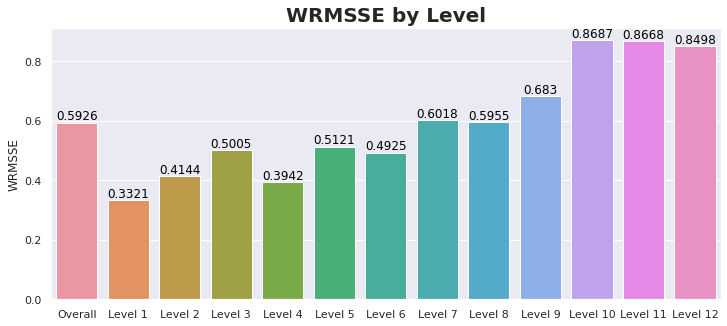

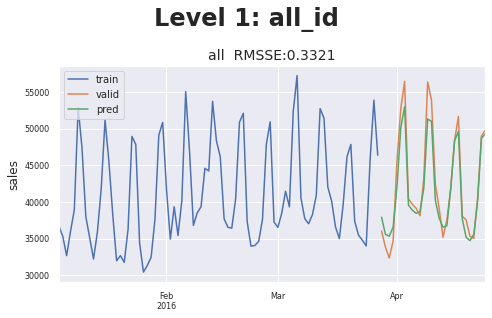

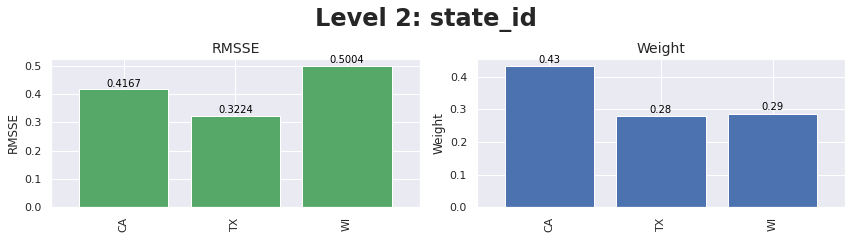

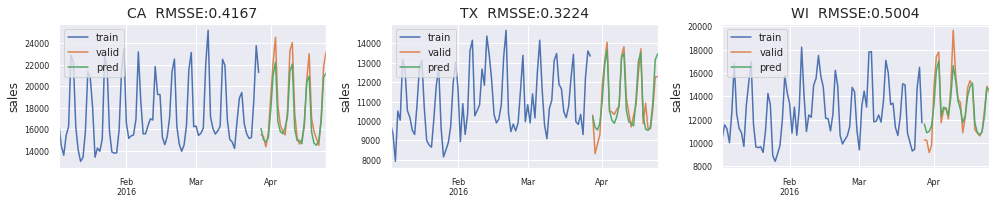

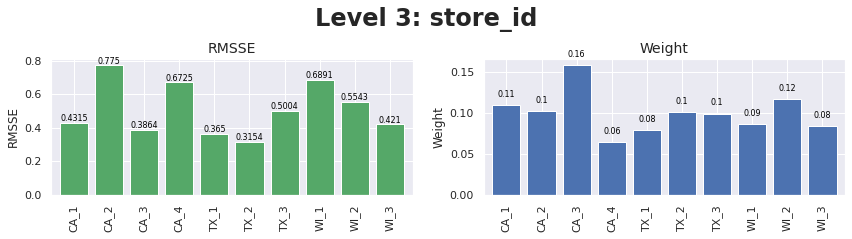

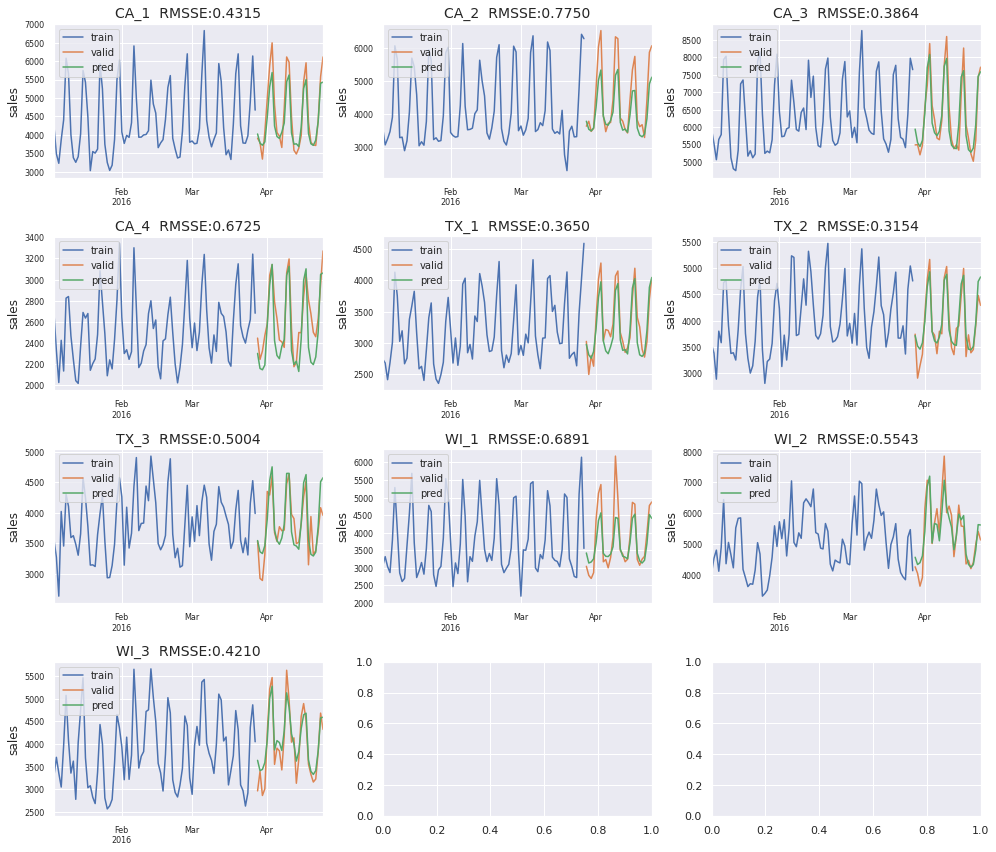

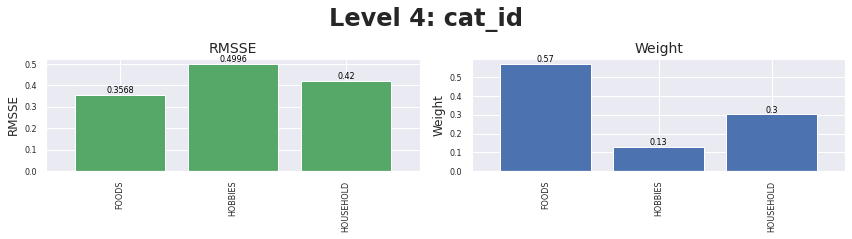

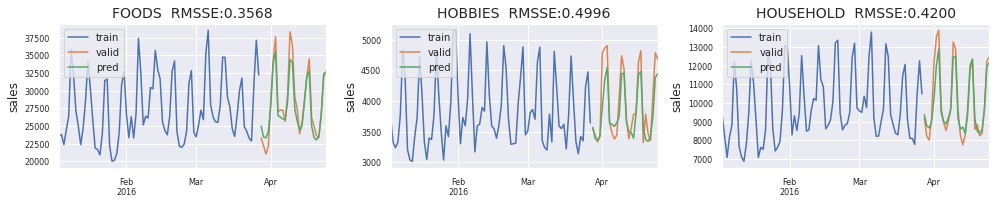

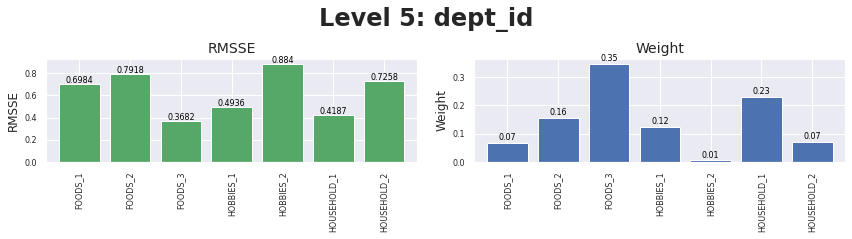

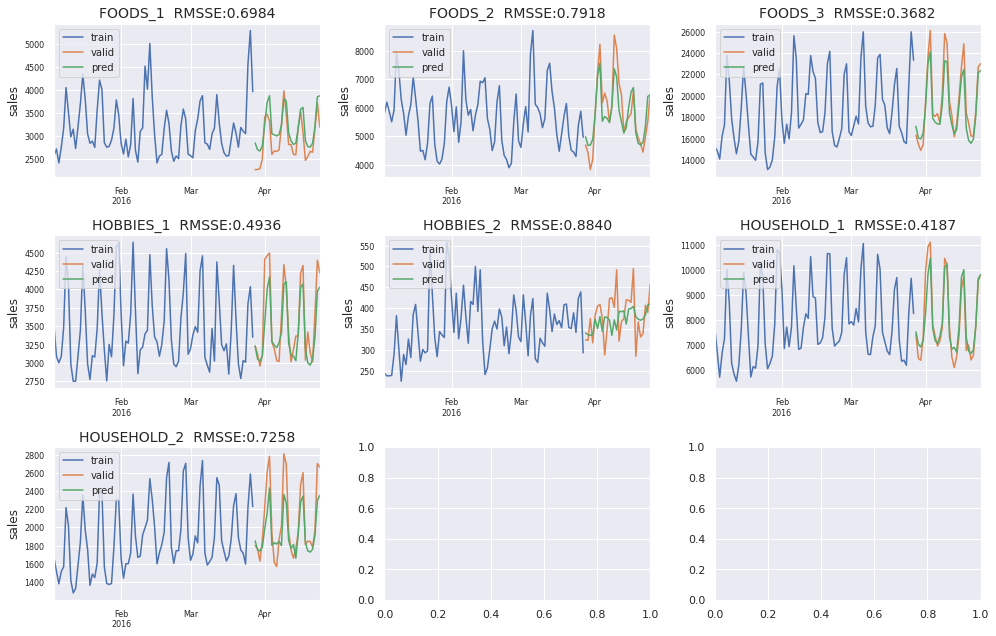

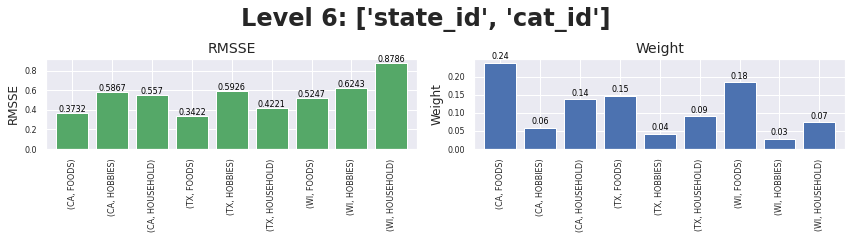

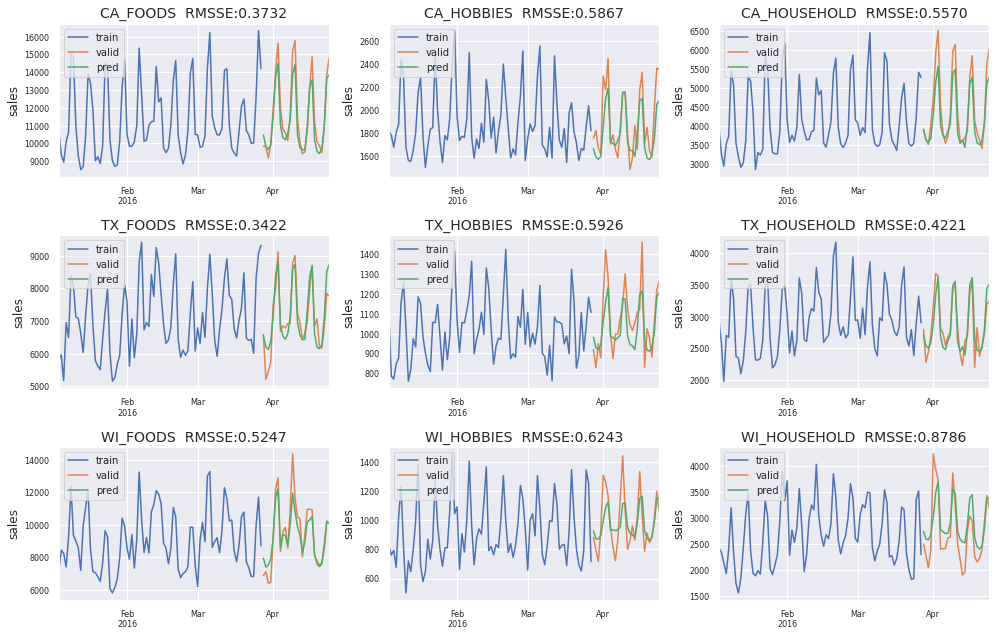

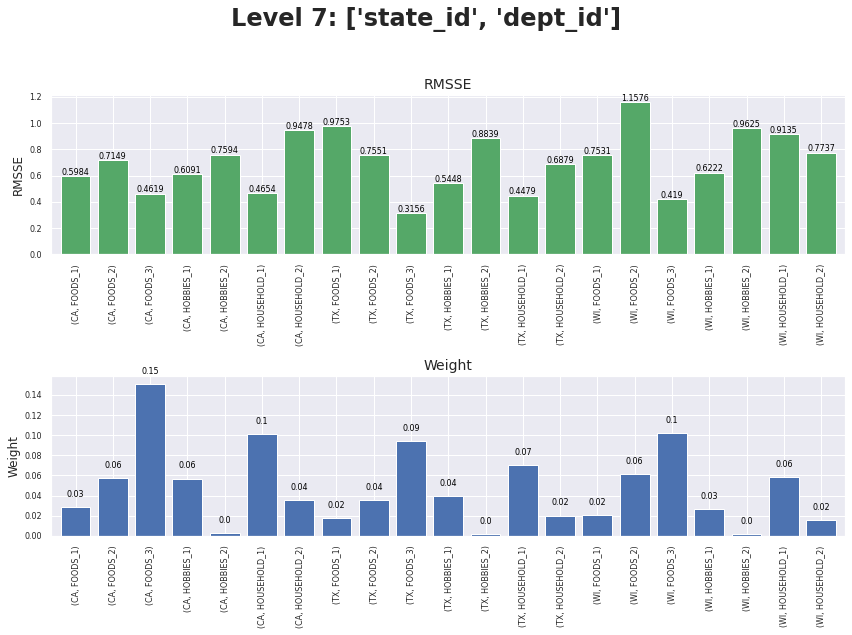

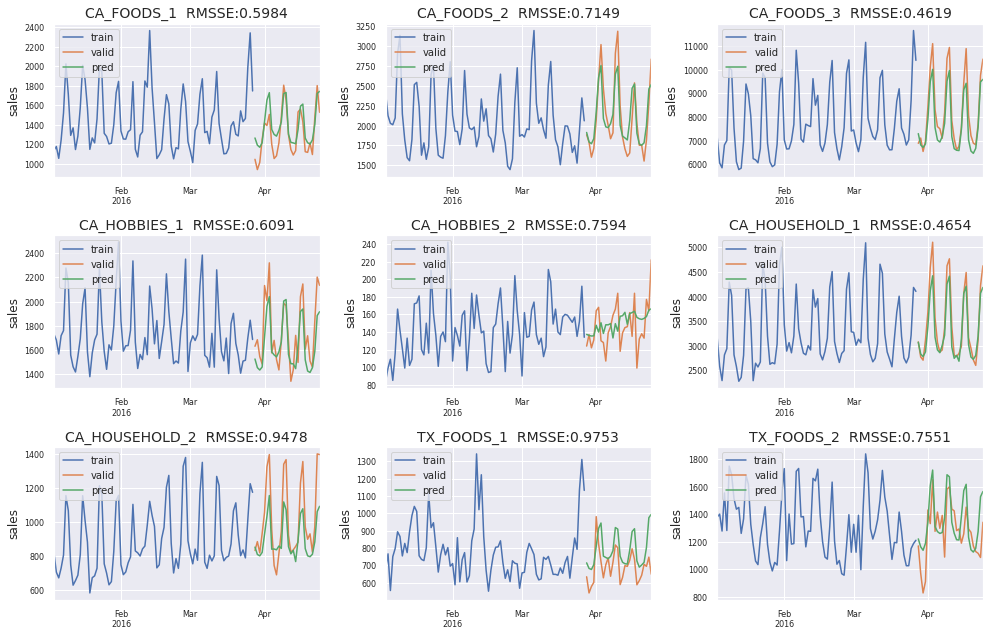

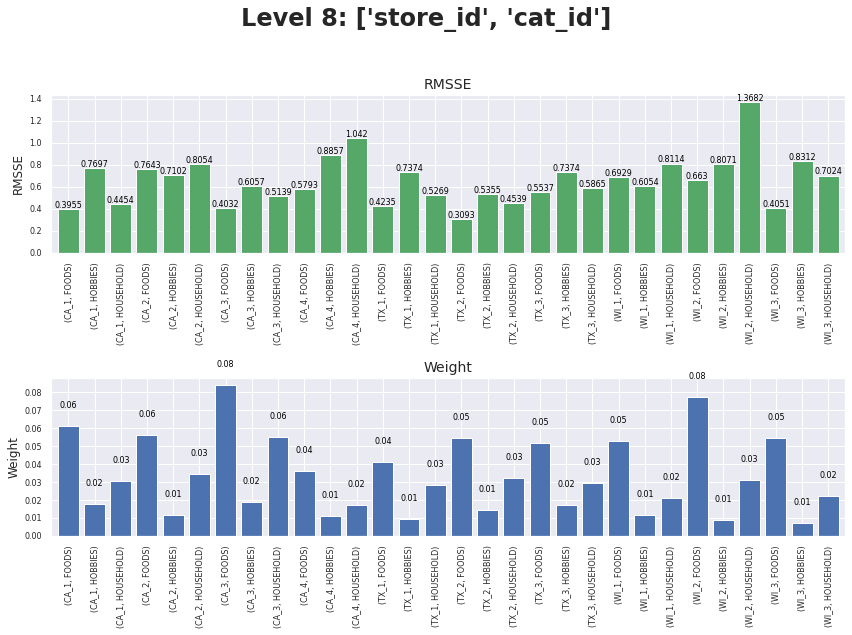

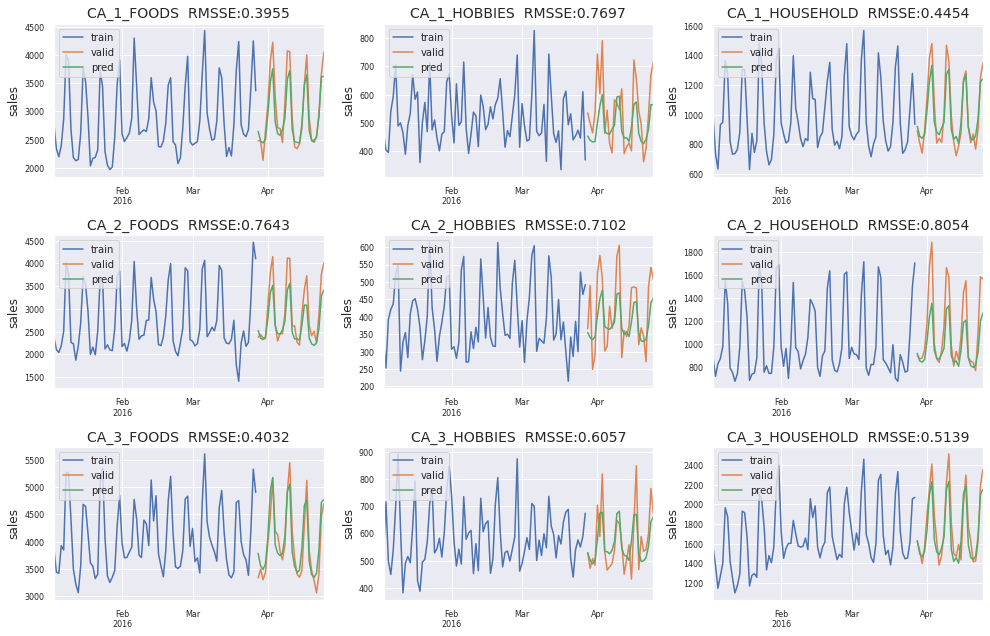

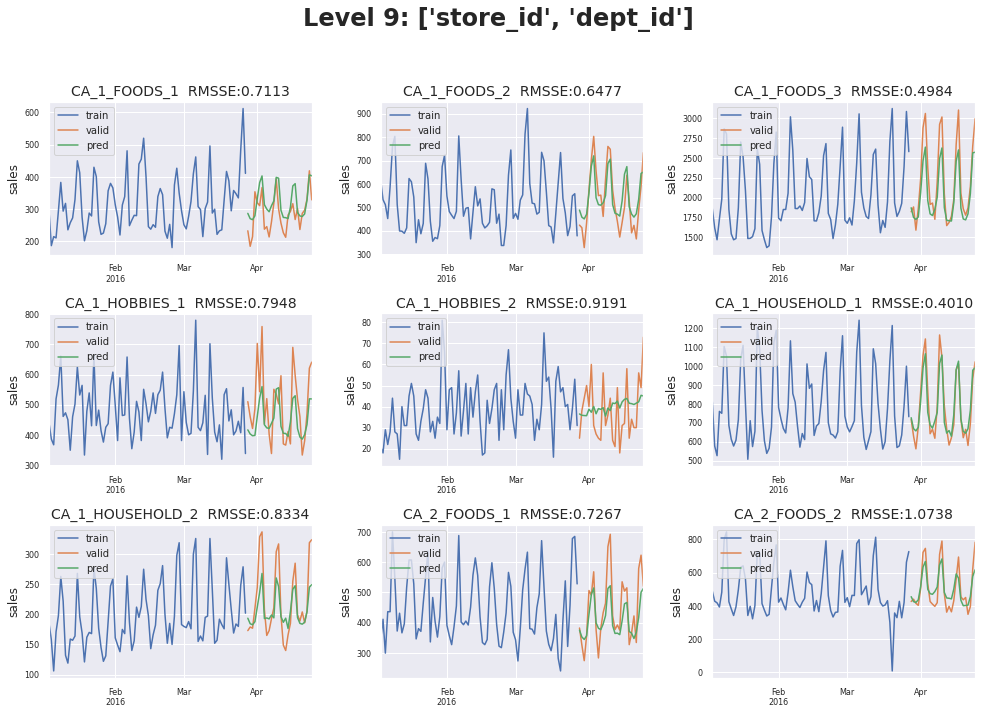

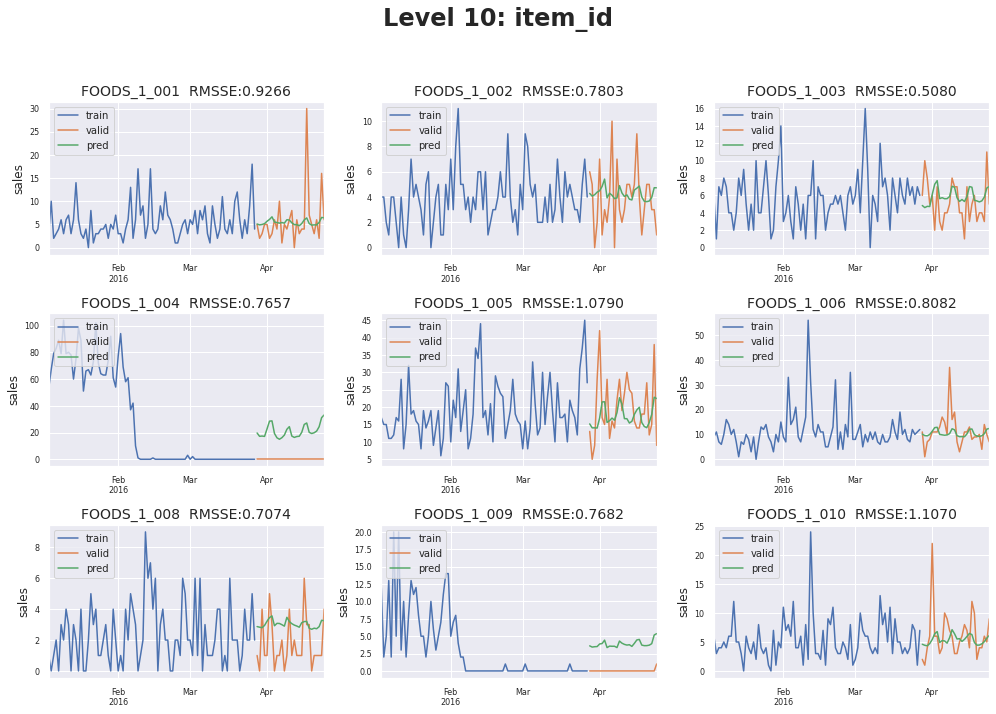

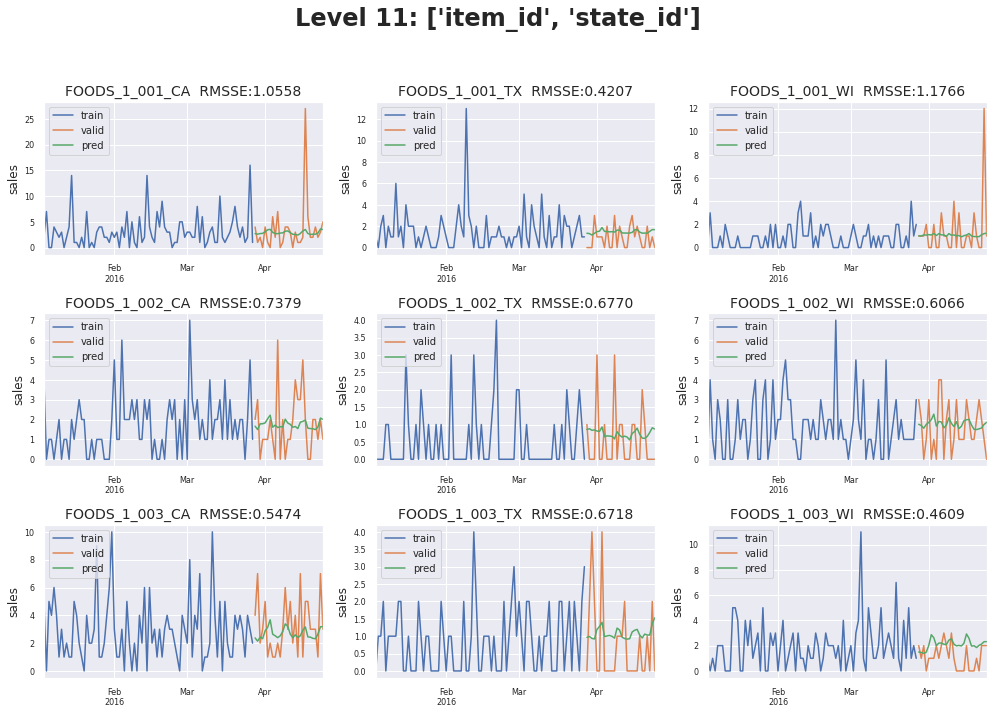

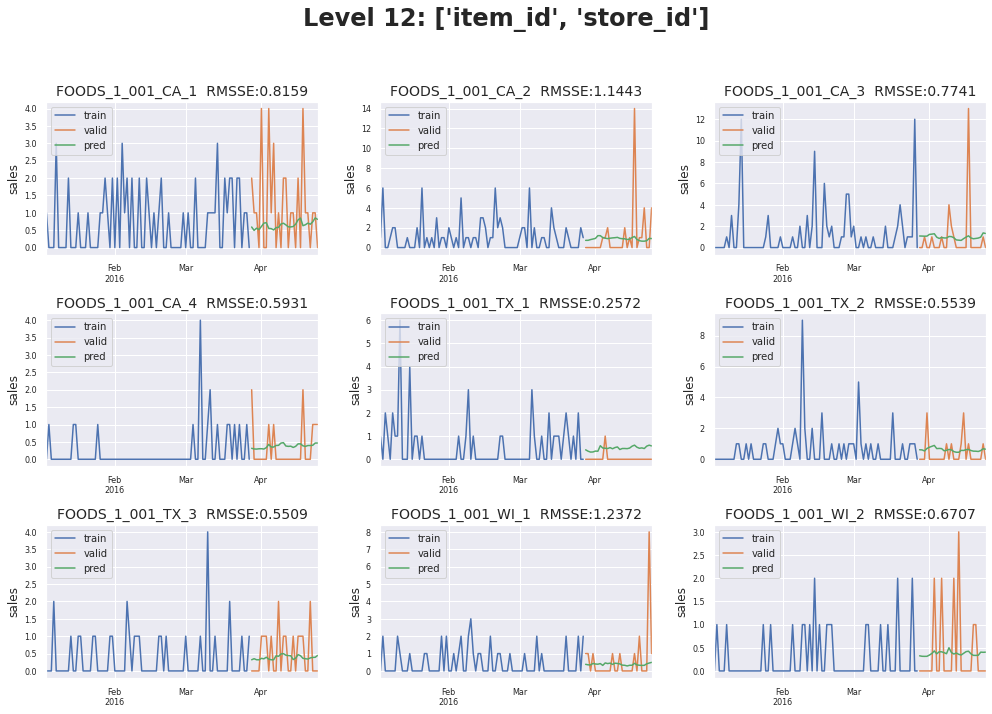

In [144]:
create_dashboard(evaluator)

## Submission

In [0]:
pred = model.predict(X_test, batch_size=10000)

In [0]:
test["demand"] = pred.clip(0)

In [55]:
test

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel,F
21525940,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1914,0.745180,1.0,1.142578,1.033203,0.983398,0.944336,0.772461,0.689941,0.927734,2,3,5,30,4,4,2,0,0,0,8.382812,0.0,0.064148,0.051727,F1
21525941,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1914,0.349883,1.0,0.714355,0.333252,0.250000,0.211060,0.377686,0.488037,0.479492,2,3,5,30,4,4,2,0,0,0,3.970703,0.0,0.000000,0.000000,F1
21525942,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1914,0.369501,0.0,0.285645,0.500000,0.416748,0.344482,0.633301,0.488037,1.166992,2,3,5,30,4,4,2,0,0,0,2.970703,0.0,0.000000,0.000000,F1
21525943,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1914,1.788827,0.0,3.000000,1.966797,2.099609,2.033203,1.900391,2.708984,2.076172,2,3,5,30,4,4,2,0,0,0,4.640625,0.0,0.000000,0.230713,F1
21525944,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1914,1.019046,1.0,0.714355,1.099609,1.133789,0.966797,1.171875,1.112305,0.959473,2,3,5,30,4,4,2,0,0,0,2.880859,0.0,0.000000,0.250000,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23233375,FOODS_3_823_WI_3_evaluation,1432,2,0,9,2,1969,0.544598,0.0,0.428467,0.466553,0.483398,0.488770,0.488770,0.689941,0.770020,1,5,5,16,3,2,0,0,0,0,2.980469,0.0,0.000000,0.333252,F28
23233376,FOODS_3_824_WI_3_evaluation,1433,2,0,9,2,1969,0.378479,0.0,0.428467,0.466553,0.483398,0.488770,0.488770,0.689941,0.770020,1,5,5,16,3,2,0,0,0,0,2.480469,0.0,0.000000,0.285645,F28
23233377,FOODS_3_825_WI_3_evaluation,1434,2,0,9,2,1969,0.574067,0.0,0.428467,0.466553,0.483398,0.488770,0.488770,0.689941,0.770020,1,5,5,16,3,2,0,0,0,0,3.980469,0.0,0.000000,0.000000,F28
23233378,FOODS_3_826_WI_3_evaluation,1435,2,0,9,2,1969,0.402825,0.0,0.428467,0.466553,0.483398,0.488770,0.488770,0.689941,0.770020,1,5,5,16,3,2,0,0,0,0,1.280273,0.0,0.000000,0.000000,F28


In [51]:
test["demand"] = pred.clip(0)
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission = sample_submission[["id"]].merge(submission, how="left", on="id")
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.745180,0.645329,0.614955,0.614866,0.666565,0.777848,0.939524,0.631369,0.801554,0.777394,0.891007,0.929879,1.207516,1.020065,0.908250,0.794126,0.706172,0.737996,0.850849,1.110860,0.966772,0.796880,0.741660,0.742977,0.838448,0.843249,1.013636,1.066916
1,HOBBIES_1_002_CA_1_validation,0.349883,0.328308,0.326567,0.317909,0.318547,0.340785,0.340655,0.249562,0.275621,0.218925,0.270932,0.277627,0.273720,0.236790,0.259065,0.200030,0.249555,0.251045,0.248909,0.250596,0.283383,0.213674,0.207916,0.241923,0.236470,0.245028,0.262123,0.257349
2,HOBBIES_1_003_CA_1_validation,0.369501,0.358972,0.356304,0.360117,0.365180,0.402258,0.457955,0.304831,0.316857,0.274343,0.320334,0.322067,0.314976,0.303205,0.294528,0.242932,0.293742,0.324818,0.376564,0.422736,0.509625,0.460480,0.482288,0.488126,0.427773,0.467404,0.546717,0.539675
3,HOBBIES_1_004_CA_1_validation,1.788827,1.579051,1.534158,1.535972,1.794004,2.182899,2.369450,1.655800,1.666285,1.614738,1.586514,1.811882,2.432839,2.112174,1.918736,1.704591,1.646787,1.636462,1.891054,2.123973,2.372625,1.819438,1.668340,1.591703,1.610702,1.851804,2.585868,2.432836
4,HOBBIES_1_005_CA_1_validation,1.019046,0.897067,0.981952,1.066501,1.180215,1.483098,1.916234,1.176439,1.195560,1.153084,1.110610,1.209781,1.599165,1.221416,1.178051,1.121397,0.976835,0.998798,1.246529,1.378556,1.401384,1.074119,1.019861,1.003221,1.037493,1.173943,1.499144,1.702519


In [52]:
submission[sample_submission.id=="FOODS_1_001_TX_2_validation"].head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
16857,FOODS_1_001_TX_2_validation,0.515457,0.484749,0.471471,0.557046,0.570687,0.589748,0.644212,0.494907,0.50907,0.466014,0.376433,0.50682,0.488425,0.452915,0.447824,0.398512,0.423222,0.507074,0.613155,0.580839,0.656796,0.513068,0.493625,0.482428,0.470911,0.410703,0.543717,0.468437


In [0]:
submission.to_csv(output+"submission"+str(VER)+".csv", index=False)